In [1]:
from kSZ_forecast_general_func import *
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
Grid = 512
MAS  = "NGP"
Snapshot = 1631

snap_info=Snap_Info()

In [7]:

def den2theta_filter(den, Rg, redshift, cosmo_model, grow_rate_index=4/7., precise=0.1):
    grid=den.shape[0]
    denk=np.fft.rfftn(den)
    kmod=fa.karray(grid)

    #ps_den, k = fa.CalPS(den, grid, mapscale=(Boxlen/grid**2)**3,kscale=2*np.pi/Boxlen)
    #k = np.hstack(([0], k, [10]))
    #f = np.hstack(([1], (ps_den-1/n)/ps_den, [0]))
    #f_filter = interp1d(k, f, fill_value = 0, bounds_error=False)
    #print(ps_den, f)
    
    denk_f = denk*np.exp(-(kmod*Rg*2*np.pi/Boxlen)**2/2)
    den_f = np.fft.irfftn(denk_f)
    
    H = cosmo.H(z=redshift).value #km/s/(Mpc/h)
    f = cosmo.Om(z=redshift)**grow_rate_index
    return H*f*den_f/c_speed
def mom2kSZ(mom, redshift, ):
    Thelen = 1200/h/cosmo.comoving_distance(z=redshift).value
    cnorm=ne0*sigma_t*Mpc2m*Boxlen*1.0/Grid*(1+redshift)**2/h
    momp_proj = np.sum(mom[:,:,:,0], axis=0)*cnorm
    
    return momp_proj

# ideal case

In [2]:
Mom_dir = "/home/chenzy/data/mommap/mom"+MAS+"_"+str(Grid)+"_"+str(Snapshot)+"_0"
Den_dir= "/home/chenzy/data/denmap/den"+MAS+"_"+str(Grid)+"_"+str(Snapshot)+"_0"
print(snap_info.get_redshift(Snapshot))

[2.023]


In [3]:
denp=np.fromfile(Den_dir, dtype=np.float32, count=Grid**3, sep="").reshape((Grid,)*3)

In [4]:
momp=snap_info.get_vel_norm(Snapshot)*np.fromfile(Mom_dir, dtype=np.float32, count=3*Grid**3, sep="").reshape(Grid,Grid,Grid,3)

In [5]:
theta_rec = den2theta(den=denp, cosmo_model= cosmo, redshift = snap_info.get_redshift(step = Snapshot))
vel_rec = theta2vel(theta=theta_rec, boxlen = Boxlen)
mom_rec = denp.reshape(Grid, Grid, Grid, 1)*vel_rec

Text(0.5, 1.0, 'ideal case, f_sky = 0.03, Planck,  dL = 1200Mpc/h')

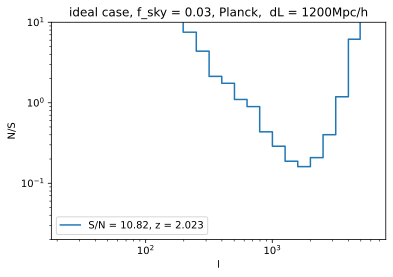

In [8]:
Thelen = 1200/h/cosmo.comoving_distance(z=snap_info.get_redshift(Snapshot)).value
momp_proj = mom2kSZ(mom=momp, redshift=snap_info.get_redshift(Snapshot), )
mom_rec_proj = mom2kSZ(mom=mom_rec, redshift=snap_info.get_redshift(Snapshot), )
cor, l = fa.CalCor2d(mom_rec_proj, momp_proj, Grid, mapscale=(Thelen/Grid**2)**2,kscale=2*np.pi/Thelen)
ps_rec, l = fa.CalPS2d(mom_rec_proj, Grid, mapscale=(Thelen/Grid**2)**2,kscale=2*np.pi/Thelen)
ps, l = fa.CalPS2d(momp_proj, Grid, mapscale=(Thelen/Grid**2)**2,kscale=2*np.pi/Thelen)


f_sky = 1400/(4*np.pi*(180/np.pi)**2)
CMB_survey="Planck"
fig, ax = plt.subplots()

l_array, NS, SN = SN_prediction(l=l, cor=cor, PS_rec=ps_rec, f_sky=f_sky, CMB_survey=CMB_survey)
ax.step(l_array, NS, label = "S/N = "+str(np.round(SN, 2))+", z = "+str(snap_info.get_redshift(step = Snapshot)[0]))

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim(0.02, 10)
ax.set_xlabel("l")
ax.set_ylabel("N/S")
ax.legend()
ax.set_title("ideal case, f_sky = "+str(np.round(f_sky,2))+", "+CMB_survey+",  dL = 1200Mpc/h")

# halo case

In [5]:
halox,halov, mh =ReadHalos_np(zstep=Snapshot)

In [10]:
denh = den_NGP(halox, grid = Grid)

In [11]:
thetah_rec = den2theta(den=denh, cosmo_model= cosmo, redshift = snap_info.get_redshift(step = Snapshot))
velh_rec = theta2vel(theta=thetah_rec, boxlen = Boxlen)
momh_rec = denh.reshape(Grid, Grid, Grid, 1)*velh_rec

Text(0.5, 1.0, 'ideal case, f_sky = 0.03, Planck,  dL = 1200Mpc/h')

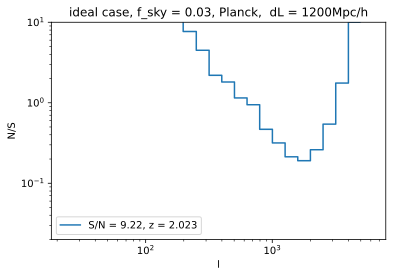

In [12]:
Thelen = 1200/h/cosmo.comoving_distance(z=snap_info.get_redshift(Snapshot)).value
momp_proj = mom2kSZ(mom=momp, redshift=snap_info.get_redshift(Snapshot), )
momh_rec_proj = mom2kSZ(mom=momh_rec, redshift=snap_info.get_redshift(Snapshot), )
cor, l = fa.CalCor2d(momh_rec_proj, momp_proj, Grid, mapscale=(Thelen/Grid**2)**2,kscale=2*np.pi/Thelen)
ps_rec, l = fa.CalPS2d(momh_rec_proj, Grid, mapscale=(Thelen/Grid**2)**2,kscale=2*np.pi/Thelen)
ps, l = fa.CalPS2d(momp_proj, Grid, mapscale=(Thelen/Grid**2)**2,kscale=2*np.pi/Thelen)


f_sky = 1400/(4*np.pi*(180/np.pi)**2)
CMB_survey="Planck"
fig, ax = plt.subplots()

l_array, NS, SN = SN_prediction(l=l, cor=cor, PS_rec=ps_rec, f_sky=f_sky, CMB_survey=CMB_survey)
ax.step(l_array, NS, label = "S/N = "+str(np.round(SN, 2))+", z = "+str(snap_info.get_redshift(step = Snapshot)[0]))

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim(0.02, 10)
ax.set_xlabel("l")
ax.set_ylabel("N/S")
ax.legend()
ax.set_title("halo case, f_sky = "+str(np.round(f_sky,2))+", "+CMB_survey+",  dL = 1200Mpc/h")

# halo selection case

In [20]:
#pm=2.775*10**11*Om0*Boxlen**3/3072.**3 #M_sun h^2 /Mpc^-3
halo_mass = mh*pm
N = int(4*10**-4*Boxlen**3)
label = np.where(halo_mass>10**12)[0]
np.random.shuffle(label)
label = label[:N]

In [21]:
denh = den_NGP(halox[label,:], grid = Grid)

In [15]:
thetah_rec = den2theta(den=denh, cosmo_model= cosmo, redshift = snap_info.get_redshift(step = Snapshot))
velh_rec = theta2vel(theta=thetah_rec, boxlen = Boxlen)
momh_rec = denh.reshape(Grid, Grid, Grid, 1)*velh_rec

Text(0.5, 1.0, 'ideal case, f_sky = 0.03, Planck,  dL = 1200Mpc/h')

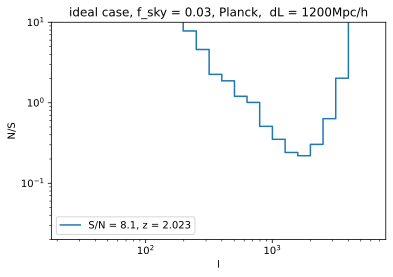

In [16]:
Thelen = 1200/h/cosmo.comoving_distance(z=snap_info.get_redshift(Snapshot)).value
momp_proj = mom2kSZ(mom=momp, redshift=snap_info.get_redshift(Snapshot), )
momh_rec_proj = mom2kSZ(mom=momh_rec, redshift=snap_info.get_redshift(Snapshot), )
cor, l = fa.CalCor2d(momh_rec_proj, momp_proj, Grid, mapscale=(Thelen/Grid**2)**2,kscale=2*np.pi/Thelen)
ps_rec, l = fa.CalPS2d(momh_rec_proj, Grid, mapscale=(Thelen/Grid**2)**2,kscale=2*np.pi/Thelen)
ps, l = fa.CalPS2d(momp_proj, Grid, mapscale=(Thelen/Grid**2)**2,kscale=2*np.pi/Thelen)


f_sky = 1400/(4*np.pi*(180/np.pi)**2)
CMB_survey="Planck"
fig, ax = plt.subplots()

l_array, NS, SN = SN_prediction(l=l, cor=cor, PS_rec=ps_rec, f_sky=f_sky, CMB_survey=CMB_survey)
ax.step(l_array, NS, label = "S/N = "+str(np.round(SN, 2))+", z = "+str(snap_info.get_redshift(step = Snapshot)[0]))

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim(0.02, 10)
ax.set_xlabel("l")
ax.set_ylabel("N/S")
ax.legend()
ax.set_title("ideal case, f_sky = "+str(np.round(f_sky,2))+", "+CMB_survey+",  dL = 1200Mpc/h")
#no filter

In [17]:
thetah_rec = den2theta_filter(den=denh, Rg=3.2, redshift=snap_info.get_redshift(Snapshot), cosmo_model=cosmo)
velh_rec = theta2vel(theta=thetah_rec, boxlen = Boxlen)
momh_rec = denh.reshape(Grid, Grid, Grid, 1)*velh_rec

Text(0.5, 1.0, 'halo selection case, f_sky = 0.03, Planck,  dL = 1200Mpc/h, z = 2.023')

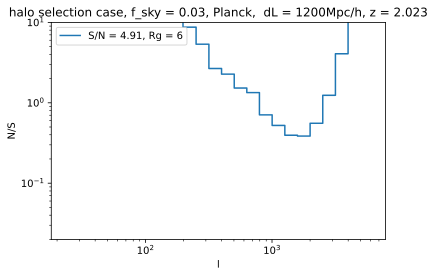

In [22]:
Thelen = 1200/h/cosmo.comoving_distance(z=snap_info.get_redshift(Snapshot)).value
f_sky = 1400/(4*np.pi*(180/np.pi)**2)
CMB_survey="Planck"
fig, ax = plt.subplots()

for Rg in [6]:
    thetah_rec = den2theta_filter(den=denh, Rg=Rg, redshift=snap_info.get_redshift(Snapshot), cosmo_model=cosmo)
    velh_rec = theta2vel(theta=thetah_rec, boxlen = Boxlen)
    momh_rec = denh.reshape(Grid, Grid, Grid, 1)*velh_rec
    momp_proj = mom2kSZ(mom=momp, redshift=snap_info.get_redshift(Snapshot), )
    momh_rec_proj = mom2kSZ(mom=momh_rec, redshift=snap_info.get_redshift(Snapshot), )
    cor, l = fa.CalCor2d(momh_rec_proj, momp_proj, Grid, mapscale=(Thelen/Grid**2)**2,kscale=2*np.pi/Thelen)
    ps_rec, l = fa.CalPS2d(momh_rec_proj, Grid, mapscale=(Thelen/Grid**2)**2,kscale=2*np.pi/Thelen)
    ps, l = fa.CalPS2d(momp_proj, Grid, mapscale=(Thelen/Grid**2)**2,kscale=2*np.pi/Thelen)
    l_array, NS, SN = SN_prediction(l=l, cor=cor, PS_rec=ps_rec, f_sky=f_sky, CMB_survey=CMB_survey)
    ax.step(l_array, NS, label = "S/N = "+str(np.round(SN, 2))+", Rg = "+str(Rg))

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim(0.02, 10)
ax.set_xlabel("l")
ax.set_ylabel("N/S")
ax.legend()
ax.set_title("halo selection case, f_sky = "+str(np.round(f_sky,2))+", "+CMB_survey+",  dL = 1200Mpc/h"+", z = "+str(snap_info.get_redshift(step = Snapshot)[0]))
#with filter

# RSD case

In [6]:
Thelen = 1200/h/cosmo.comoving_distance(z=snap_info.get_redshift(Snapshot)).value
f_sky = 1
CMB_survey="Planck"
cnorm=ne0*sigma_t*Mpc2m*Boxlen*1.0/Grid*(1+snap_info.get_redshift(Snapshot))**2/h
velp = momden2vel(denp, momp)
thetap = vel2theta(velp, Boxlen)

In [7]:
the=(45)*np.pi/180
n_rsd=np.array([np.cos(the),np.sin(the),0])
momp_proj=proj1(momp,the)*cnorm

In [8]:
halo_mass = mh*pm
N = int(40*10**-4*Boxlen**3)
label = np.where(halo_mass>10**12)[0]
#np.random.shuffle(label)
label = label[:N]

In [9]:
#del velp, denp, momp
#haloxx_rsd=RSD(halox[label,:]*Boxlen,halov[label,:]*(1+snap_info.get_redshift(Snapshot)),n_rsd,cosmo.H(snap_info.get_redshift(Snapshot)).value)%Boxlen   #Mpc/h
haloxx_rsd=add_RSD(halox*Boxlen,halov*(1+snap_info.get_redshift(Snapshot)),n_rsd,cosmo.H(snap_info.get_redshift(Snapshot)).value)%Boxlen   #Mpc/h
denh_rsd=den_NGP(haloxx_rsd,Grid)
W,kx,ky,kz=wiener_filter_theta_esti(denh_rsd,thetap, Boxlen)
#del thetap
thetah_rsd_rec=wiener_filter_den2theta(denh_rsd,W,kx,ky,kz, Boxlen)
#del W,kx,ky,kz
velh_rsd_rec=theta2vel(thetah_rsd_rec, Boxlen)

/home/chenzy/code/kSZ_forecast/kSZ_forecast_general_func.py:174: RuntimeWarning: invalid value encountered in true_divide
  W=cor_the_delta_f[0]/ps_delta[0]


In [10]:
pkden,kden=fa.CalPS(denp,Grid,mapscale=(Boxlen/Grid**2)**3,kscale=2*np.pi/Boxlen)
denh_rsd_fw = wiener_filter_den(denh_rsd,pkden,kden,2*np.pi/Boxlen,40*10**-4,Grid)

In [11]:
#denh_rsd_fg = den_filter_g(denh_rsd, Rg=5, Boxlen=Boxlen)
momh_rsd_rec=velh_rsd_rec*(denh_rsd_fw).reshape(Grid,Grid,Grid,1)
momh_rsd_rec_proj = proj1(momh_rsd_rec, the)*cnorm

cor, l = fa.CalCor2d(momh_rsd_rec_proj, momp_proj, Grid, mapscale=(Thelen/Grid**2)**2,kscale=2*np.pi/Thelen)
ps_rec, l = fa.CalPS2d(momh_rsd_rec_proj, Grid, mapscale=(Thelen/Grid**2)**2,kscale=2*np.pi/Thelen)
ps, l = fa.CalPS2d(momp_proj, Grid, mapscale=(Thelen/Grid**2)**2,kscale=2*np.pi/Thelen)

Text(0.5, 1.0, 'RSD case, f_sky = 1, Planck,  dL = 1200Mpc/h, z = 2.023')

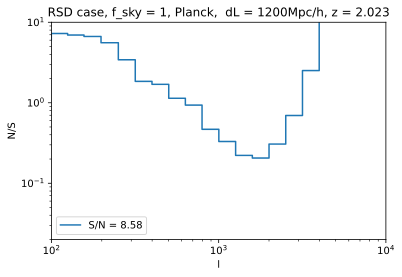

In [20]:
fig, ax = plt.subplots()
l_array, NS, SN = SN_prediction(l=l, cor=cor, PS_rec=ps_rec, f_sky=1400/(4*np.pi*(180/np.pi)**2), CMB_survey=CMB_survey)

ax.step(l_array, NS, label = "S/N = "+str(np.round(SN, 2)))

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(100, 10**4)
ax.set_ylim(0.02, 10)
ax.set_xlabel("l")
ax.set_ylabel("N/S")
ax.legend()
ax.set_title("RSD case, f_sky = "+str(np.round(f_sky,2))+", "+CMB_survey+",  dL = 1200Mpc/h"+", z = "+str(snap_info.get_redshift(step = Snapshot)[0]))

# real survey case

In [14]:
Thelen = 1200/h/cosmo.comoving_distance(z=snap_info.get_redshift(Snapshot)).value
f_sky = 1
CMB_survey="Planck"
cnorm=ne0*sigma_t*Mpc2m*Boxlen*1.0/Grid*(1+snap_info.get_redshift(Snapshot))**2/h
velp = momden2vel(denp, momp)
thetap = vel2theta(velp, Boxlen)

In [15]:
the=(45)*np.pi/180
n_rsd=np.array([np.cos(the),np.sin(the),0])
momp_proj=proj1(momp,the)*cnorm

In [21]:
halo_mass = mh*pm
N = int(40*10**-4*Boxlen**3)
label = np.where(halo_mass>10**12)[0]
#np.random.shuffle(label)
label = label[:N]

In [22]:
#del velp, denp, momp
haloxx_rsd=add_RSD(halox[label,:]*Boxlen,halov[label,:]*(1+snap_info.get_redshift(Snapshot)),n_rsd,cosmo.H(snap_info.get_redshift(Snapshot)).value)%Boxlen   #Mpc/h
denh_rsd=den_NGP(haloxx_rsd,Grid)
W,kx,ky,kz=wiener_filter_theta_esti(denh_rsd,thetap, Boxlen)
#del thetap
thetah_rsd_rec=wiener_filter_den2theta(denh_rsd,W,kx,ky,kz, Boxlen)
#del W,kx,ky,kz
velh_rsd_rec=theta2vel(thetah_rsd_rec, Boxlen)

In [23]:
pkden,kden=fa.CalPS(denp,Grid,mapscale=(Boxlen/Grid**2)**3,kscale=2*np.pi/Boxlen)
denh_rsd_fw = wiener_filter_den(denh_rsd,pkden,kden,2*np.pi/Boxlen,40*10**-4,Grid)

In [24]:
#denh_rsd_fg = den_filter_g(denh_rsd, Rg=5, Boxlen=Boxlen)
momh_rsd_rec=velh_rsd_rec*(denh_rsd_fw).reshape(Grid,Grid,Grid,1)
momh_rsd_rec_proj = proj1(momh_rsd_rec, the)*cnorm

cor, l = fa.CalCor2d(momh_rsd_rec_proj, momp_proj, Grid, mapscale=(Thelen/Grid**2)**2,kscale=2*np.pi/Thelen)
ps_rec, l = fa.CalPS2d(momh_rsd_rec_proj, Grid, mapscale=(Thelen/Grid**2)**2,kscale=2*np.pi/Thelen)
ps, l = fa.CalPS2d(momp_proj, Grid, mapscale=(Thelen/Grid**2)**2,kscale=2*np.pi/Thelen)

Text(0, 0.5, 'r')

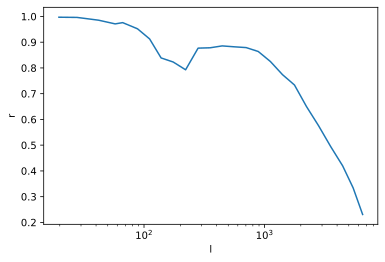

In [30]:
plt.plot(l, cor/np.sqrt(ps*ps_rec))
plt.xscale("log")
#plt.yscale("log")
plt.xlabel("l")
plt.ylabel("r")

Text(0.5, 1.0, 'real survey case, f_sky = 1, ACT,  dL = 1200Mpc/h, z = 2.023')

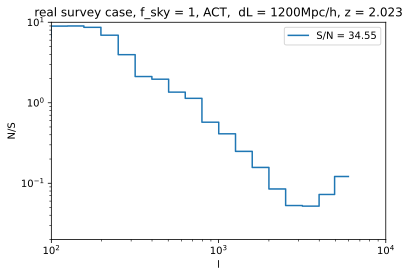

In [30]:
fig, ax = plt.subplots()
CMB_survey = "ACT"
l_array, NS, SN = SN_prediction(l=l, cor=cor, PS_rec=ps_rec, f_sky=1400/(4*np.pi*(180/np.pi)**2), CMB_survey=CMB_survey)

ax.step(l_array, NS, label = "S/N = "+str(np.round(SN, 2)))

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(100, 10**4)
ax.set_ylim(0.02, 10)
ax.set_xlabel("l")
ax.set_ylabel("N/S")
ax.legend()
ax.set_title("real survey case, f_sky = "+str(np.round(f_sky,2))+", "+CMB_survey+",  dL = 1200Mpc/h"+", z = "+str(snap_info.get_redshift(step = Snapshot)[0]))

Text(0, 0.5, 'r')

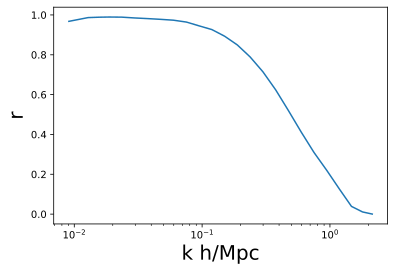

In [74]:
#r_vel, k = fa.CalRvector(velp, velh_rsd_rec, Grid)
plt.plot(k*2*np.pi/Boxlen, r_vel)
plt.xscale("log")
#plt.yscale("log")
plt.xlabel("k h/Mpc", fontsize=20)
plt.ylabel("r", fontsize=20)

In [34]:
label = np.where(halo_mass>10**13)[0]
np.random.shuffle(label)
label = label[:100]

In [36]:
def get_halov(f,X):
    from tqdm import tqdm
    grid=f.shape[0]
    t=np.zeros((len(X[:,0]),3))


    for i in tqdm(range(len(t))):
        x=X[i,0];y=X[i,1];z=X[i,2]
        w1=(x-np.int(x))*(y-np.int(y))*(z-np.int(z))*f[np.int(1+x)%grid,np.int(1+y)%grid,np.int(1+z)%grid]
        w2=(1-x+np.int(x))*(y-np.int(y))*(z-np.int(z))*f[np.int(x)%grid,np.int(1+y)%grid,np.int(1+z)%grid]
        w3=(x-np.int(x))*(1-y+np.int(y))*(z-np.int(z))*f[np.int(1+x)%grid,np.int(y)%grid,np.int(1+z)%grid]
        w4=(x-np.int(x))*(y-np.int(y))*(1-z+np.int(z))*f[np.int(1+x)%grid,np.int(1+y)%grid,np.int(z)%grid]
        w5=(1-x+np.int(x))*(1-y+np.int(y))*(z-np.int(z))*f[np.int(x)%grid,np.int(y)%grid,np.int(1+z)%grid]
        w6=(1-x+np.int(x))*(y-np.int(y))*(1-z+np.int(z))*f[np.int(x)%grid,np.int(1+y)%grid,np.int(z)%grid]
        w7=(x-np.int(x))*(1-y+np.int(y))*(1-z+np.int(z))*f[np.int(1+x)%grid,np.int(y)%grid,np.int(z)%grid]
        w8=(1-x+np.int(x))*(1-y+np.int(y))*(1-z+np.int(z))*f[np.int(x)%grid,np.int(y)%grid,np.int(z)%grid]
        t[i,:]=w1+w2+w3+w4+w5+w6+w7+w8

    return t
halov_rec = get_halov(velh_rsd_rec, haloxx_rsd[label,:]*Grid*1.0/Boxlen)*c_speed

  0%|          | 0/100 [00:00<?, ?it/s]/opt/conda/conda-4.12.0/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == "__main__":
/opt/conda/conda-4.12.0/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify 

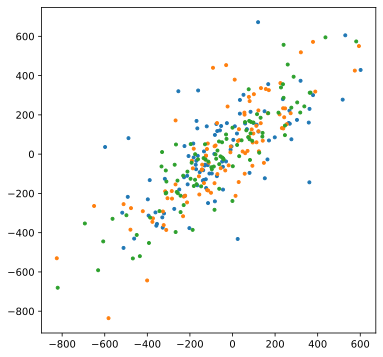

In [49]:
fig, ax = plt.subplots(figsize = (6, 6))
ax.plot(halov_rec, halov[label, :], '.')

In [40]:
def correlation_coefficient(v1, v2):
    return np.mean(v1*v2)/np.sqrt(np.mean(v1**2))/np.sqrt(np.mean(v2**2))

In [41]:
correlation_coefficient(halov_rec, halov[label, :])

0.7837337407505672

In [50]:
def cal_halov_los(halov, the):
    return np.sum(halov*the, axis=1)


In [45]:
correlation_coefficient(halov_los(halov[label,:], the), halov_los(halov_rec, the))

0.7407774318969913

100%|██████████| 10000/10000 [00:01<00:00, 7871.27it/s]


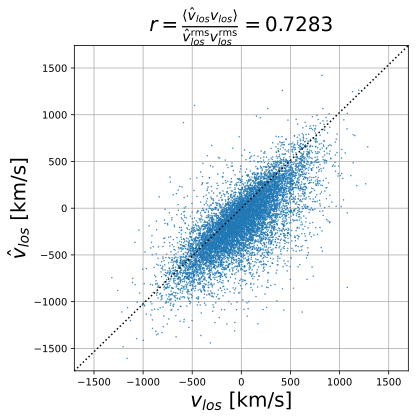

In [73]:
import warnings
warnings.filterwarnings("ignore")

label = np.where(halo_mass>10**13)[0]
np.random.shuffle(label)
label = label[:10000]

halov_rsd_rec = get_halov(velh_rsd_rec, haloxx_rsd[label,:]*Grid*1.0/Boxlen)*c_speed
halov_los = cal_halov_los(halov[label,:], the)
halov_rsd_rec_los = cal_halov_los(halov_rsd_rec, the)

r = np.mean(halov_los*halov_rsd_rec_los)/np.std(halov_los)/np.std(halov_rsd_rec_los)

fig, ax = plt.subplots(figsize = (6, 6))
ax.plot(halov_los, halov_rsd_rec_los, '.', ms =1)
ax.plot([-5*np.std(halov_los), 5*np.std(halov_los)], [-5*np.std(halov_rsd_rec_los), 5*np.std(halov_rsd_rec_los)], 'k:')
ax.set_xlim(-5*np.std(halov_los), 5*np.std(halov_los))
ax.set_ylim(-5*np.std(halov_rsd_rec_los), 5*np.std(halov_rsd_rec_los))
ax.set_xlabel("$v_{los}$ [km/s]", fontsize=20)
ax.set_ylabel(r"$\hat v_{los}$ [km/s]", fontsize=20)
ax.set_title(r"$r=\frac{\langle\hat v_{los} v_{los} \rangle}{\hat v^{\rm rms}_{los} v^{\rm rms}_{los} }=$"+str(np.round(r, 4)), fontsize = 20)
ax.grid()

In [70]:
label

array([51474, 25988, 82936, ..., 60387, 82127, 64124])

In [2]:
from  scipy.special import j1
from kSZ_forecast_general_func import *
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
Grid = 512
MAS  = "NGP"
Snapshot = 1631

snap_info=Snap_Info()

Thelen = Boxlen/h/cosmo.comoving_distance(z=snap_info.get_redshift(Snapshot)).value
cnorm=ne0*sigma_t*Mpc2m*Boxlen*1.0/Grid*(1+snap_info.get_redshift(Snapshot))**2/h  # proj mom: km/h -> dkSZ/CMB

the_los=(45)*np.pi/180
n_rsd=np.array([np.cos(the_los),np.sin(the_los),0])

n_halo =np.array([    1,     2,     3,     5,    7,     9,    30,   70])*10**-4 #8
lgM_min=np.array([12.86, 12.68, 12.55, 12.41, 12.3, 12.23, 11.82, 11.5])

Den_dir= "/home/chenzy/data/denmap/den"+MAS+"_"+str(Grid)+"_"+str(Snapshot)+"_0"
Mom_dir = "/home/chenzy/data/mommap/mom"+MAS+"_"+str(Grid)+"_"+str(Snapshot)+"_0"
momp=snap_info.get_vel_norm(Snapshot)*np.fromfile(Mom_dir, dtype=np.float32, count=3*Grid**3, sep="").reshape(Grid,Grid,Grid,3)
denp=np.fromfile(Den_dir, dtype=np.float32, count=Grid**3, sep="").reshape((Grid,)*3)
velp = momden2vel(denp, momp)
momp = (denp-1).reshape(Grid, Grid, Grid,1)*velp
momp_proj=proj1(momp,the_los)*cnorm
halox,halov, mh =ReadHalos_np(zstep=Snapshot)
halo_mass = mh*pm

In [6]:
mass_selection_label1 = 1
#mass_selection_label2 = 1
den_method = 0   #NGP
vel_method = 0   #thetap
CMB_survey = "ACT"

pkden,kden=fa.CalPS(denp,Grid,mapscale=(Boxlen/Grid**2)**3,kscale=2*np.pi/Boxlen)
velp = momden2vel(denp, momp)
thetap = vel2theta(velp, Boxlen)

for i in range(len(lgM_min)):
    mass_selection_label1 = i

    lgM_min1= lgM_min[mass_selection_label1]
    n_halo1 = n_halo[mass_selection_label1]
    label1 = np.where(halo_mass>10**lgM_min1)[0]
    print("Halo sample to reconstruct vel: n = "+str(n_halo1*10**4)+"$10^{-4}$ lgM_min "+str(lgM_min1))
    print("N=",len(label1))
    
    #del velp, denp, momp
    haloxx_rsd=add_RSD(halox[label1,:]*Boxlen,halov[label1,:]*(1+snap_info.get_redshift(Snapshot)),n_rsd,cosmo.H(snap_info.get_redshift(Snapshot)).value)%Boxlen   #Mpc/h
    denh_rsd=den_NGP(haloxx_rsd,Grid)
    W,kx,ky,kz=wiener_filter_theta_esti(denh_rsd,thetap, Boxlen)
    #del thetap
    thetah_rsd_rec=wiener_filter_den2theta(denh_rsd,W,kx,ky,kz, Boxlen)
    #del W,kx,ky,kz
    velh_rsd_rec=theta2vel(thetah_rsd_rec, Boxlen)
    
    
    denh_rsd_fw = wiener_filter_den(denh_rsd,pkden,kden,2*np.pi/Boxlen,40*10**-4,Grid)
    
    momh_rsd_rec=velh_rsd_rec*(denh_rsd_fw).reshape(Grid,Grid,Grid,1)
    momh_rsd_rec_proj = proj1(momh_rsd_rec, the_los)*cnorm

    cor, l = fa.CalCor2d(momh_rsd_rec_proj, momp_proj, Grid, mapscale=(Thelen/Grid**2)**2,kscale=2*np.pi/Thelen)
    ps_rec, l = fa.CalPS2d(momh_rsd_rec_proj, Grid, mapscale=(Thelen/Grid**2)**2,kscale=2*np.pi/Thelen)
    ps, l = fa.CalPS2d(momp_proj, Grid, mapscale=(Thelen/Grid**2)**2,kscale=2*np.pi/Thelen)
    
    CMB_survey = "ACT"
    l_array, NS, SN = SN_prediction_tomography(l=l, cor=cor, PS_rec=ps_rec, f_sky=1400/(4*np.pi*(180/np.pi)**2), CMB_survey=CMB_survey)
    print("S/N", SN)
    
    filename = "tomography_prediction_results/den"+str(den_method)+"vel"+str(vel_method)+"l"+str(mass_selection_label1)
    np.savez(filename, l=l, cor=cor, ps_rec=ps_rec, ps=ps, l_array=l_array, NS=NS, SN=SN)


Halo sample to reconstruct vel: n = 1.0$10^{-4}$ lgM_min 12.86
N= 160857
S/N 27.92517973236245
Halo sample to reconstruct vel: n = 2.0$10^{-4}$ lgM_min 12.68
N= 327197
S/N 32.181531777755566
Halo sample to reconstruct vel: n = 3.0000000000000004$10^{-4}$ lgM_min 12.55
N= 507861
S/N 34.6793251360554
Halo sample to reconstruct vel: n = 5.0$10^{-4}$ lgM_min 12.41
N= 823120
S/N 37.35810533452563
Halo sample to reconstruct vel: n = 7.0$10^{-4}$ lgM_min 12.3
N= 1179067
S/N 38.889439918607955
Halo sample to reconstruct vel: n = 9.0$10^{-4}$ lgM_min 12.23
N= 1472469
S/N 39.9065615124246
Halo sample to reconstruct vel: n = 30.0$10^{-4}$ lgM_min 11.82
N= 4926350
S/N 44.14648629668663
Halo sample to reconstruct vel: n = 70.0$10^{-4}$ lgM_min 11.5
N= 11636106
S/N 46.20883173923848


In [ ]:
CMB_survey = "ACT"
l_array, NS, SN = SN_prediction(l=l, cor=cor, PS_rec=ps_rec, f_sky=1400/(4*np.pi*(180/np.pi)**2), CMB_survey=CMB_survey)